In [1]:
library(ape)
library(castor)
library(dplyr)
library(tidyr)
library(stringr)
library(ggplot2)

Loading required package: Rcpp


Attaching package: ‘dplyr’


The following object is masked from ‘package:ape’:

    where


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [32]:
# Load necessary libraries
library(ape)

# Function to find nearest tips and calculate branch lengths
tree_to_near_tips <- function(tree_file, only_tip_labels = NULL) {
  # Read the tree from the Newick file
  tree <- read.tree(tree_file)
  
  # Find the nearest tips for each tip
  ids <- 1:length(tree$tip.label)
  if (!is.null(only_tip_labels)) {
    only_tip_labels <- ids[tree$tip.label %in% only_tip_labels]
    labels <- tree$tip.label[only_tip_labels]
  } else {
    only_tip_labels <- ids
    labels <- tree$tip.label
  }
  nearest_tips <- get_all_pairwise_distances(tree, only_clades = only_tip_labels)

  find_min_indices <- function(mat) {
  n <- nrow(mat)
  min_indices <- integer(n)
  
  for (i in 1:n) {
    row <- mat[i, ]
    row[i] <- Inf
    min_indices[i] <- which.min(row)
  }
  return(min_indices)
}
  min_indices <- find_min_indices(nearest_tips)
  # Create a data frame with tip1 and tip2
  tip_pairs <- data.frame(tip1 = labels, 
                          tip2 = labels[min_indices], 
                          branch_length = nearest_tips[cbind(1:length(labels), min_indices)])
  
  return(tip_pairs)
}

In [33]:
model_dist_table <- read.csv("/home/tim/project/bacterialQ/Result_nova/add_phylum_collection/trained_models_dist.csv")
colnames(model_dist_table)

[1] "model1"                 "model2"                 "Q_params.correlation"  
 [4] "state_freq.correlation" "Q_exchange.correlation" "Q_matrix.correlation"  
 [7] "Q_params.distance"      "state_freq.distance"    "Q_exchange.distance"   
[10] "Q_matrix.distance"

In [34]:
model_dist_table <- model_dist_table %>% 
    mutate(model1 = str_remove(model1, "Q.p__"), model2 = str_remove(model2, "Q.p__")) %>%
    rename(phylum1 = model1, phylum2 = model2, qdist = Q_matrix.distance, rdist = Q_exchange.distance, fdist = state_freq.distance)


In [67]:
tree_table_ref <- tree_to_near_tips("/home/tim/project/bacterialQ/analysis/phylum_tree/phylum_backbone_tree_clean.tre", only_tip_labels = unique(model_dist_table$phylum1))
tree_table_QBC <- tree_to_near_tips("/home/tim/project/bacterialQ/Result_nova/extend_global_model_test/trees/FT_Q.Bac_Class_full_backbone_simple.treefile", only_tip_labels = unique(model_dist_table$phylum1))

In [68]:
# Function to perform permutation test and generate a ggplot
# @description Perform a permutation test to compare the mean branch lengths between two tips and generate a density plot
# @param tree_table Data frame containing the tree structure with columns tip1, tip2, and branch_length
# @param dist_table Data frame containing the distance information with dynamic column names
# @param tip1 Column name in dist_table for the first tip
# @param tip2 Column name in dist_table for the second tip
# @param value Column name in dist_table for the distance value
# @param n_permutations Number of permutations to perform
# @param side Type of test: "both", "greater", or "less"
# @return A list containing the p-value of the permutation test and the ggplot object
near_tips_permutation_test <- function(tree_table, dist_table, tip1, tip2, value, n_permutations = 10000, side = "both") {
  # Extract all unique tips
  tips <- unique(c(dist_table[[tip1]], dist_table[[tip2]]))
  
  # Function to calculate mean branch length for a given tree_table
  calculate_mean_branch_length <- function(tree_table, dist_table, tip1, tip2, value) {
    tree_table %>%
      left_join(dist_table, by = c("tip1" = tip1, "tip2" = tip2)) %>%
      summarise(mean_value = mean(.data[[value]], na.rm = TRUE)) %>%
      pull(mean_value)
  }
  
  # Calculate the observed mean branch length
  observed_mean <- calculate_mean_branch_length(tree_table, dist_table, tip1, tip2, value)
  
  # Perform permutations
  permuted_means <- replicate(n_permutations, {
    # Create a deep copy of the tree_table
    permuted_tree <- tree_table
    
    # Shuffle the tips
    shuffled_tips <- sample(tips)
    tip_mapping <- setNames(shuffled_tips, tips)
    
    # Remap the tips in the tree_table
    permuted_tree <- permuted_tree %>%
      mutate(tip1 = tip_mapping[tip1],
             tip2 = tip_mapping[tip2])
    
    # Calculate the mean branch length for the permuted tree
    calculate_mean_branch_length(permuted_tree, dist_table, tip1, tip2, value)
  })
  
  # Calculate the p-value based on the side of the test
  if (side == "both") {
    p_value <- 1 - mean(abs(permuted_means) >= abs(observed_mean))
  } else if (side == "greater") {
    p_value <- 1 - mean(permuted_means >= observed_mean)
  } else if (side == "less") {
    p_value <- 1 - mean(permuted_means <= observed_mean)
  } else {
    stop("Invalid value for 'side'. Choose from 'both', 'greater', or 'less'.")
  }
  
  # Format p-value if less than 1e-3
  if (p_value < 1e-3) {
    if (p_value == 0) {
      p_value_label <- "P-value = 0"
    } else {
      p_value_label <- paste0("P-value < 1e", floor(log10(p_value)))
    }
  } else {
    p_value_label <- paste0("P-value = ", round(p_value, 6))
  }
  
  if (observed_mean > median(permuted_means)) {
    hjust <- 1.05
  } else {
    hjust <- -0.05
  }
  
  # Create the density plot
  plot <- ggplot(data.frame(permuted_means = permuted_means), aes(x = permuted_means)) +
    geom_density(fill = "blue", alpha = 0.5) +
    geom_vline(xintercept = observed_mean, color = "red", linetype = "dashed") +
    annotate("text", x = observed_mean, y = max(density(permuted_means)$y), hjust = hjust,
             label = paste0("Observed Mean:", round(observed_mean, 2)),
             vjust = -1, color = "red") +
    annotate("text", x = observed_mean, y = max(density(permuted_means)$y), 
             label = paste0("Side = ", side, "\nN =", n_permutations, "\n", p_value_label), hjust = hjust,
             vjust = 1, color = "black") +
    labs(title = "Permutation Test Density Plot", x = str_c("Permuted Mean (n=",n_permutations,")"), y = "Density")
  
  # Return the p-value and the plot separately
  return(list(p_value = p_value, plot = plot))
}

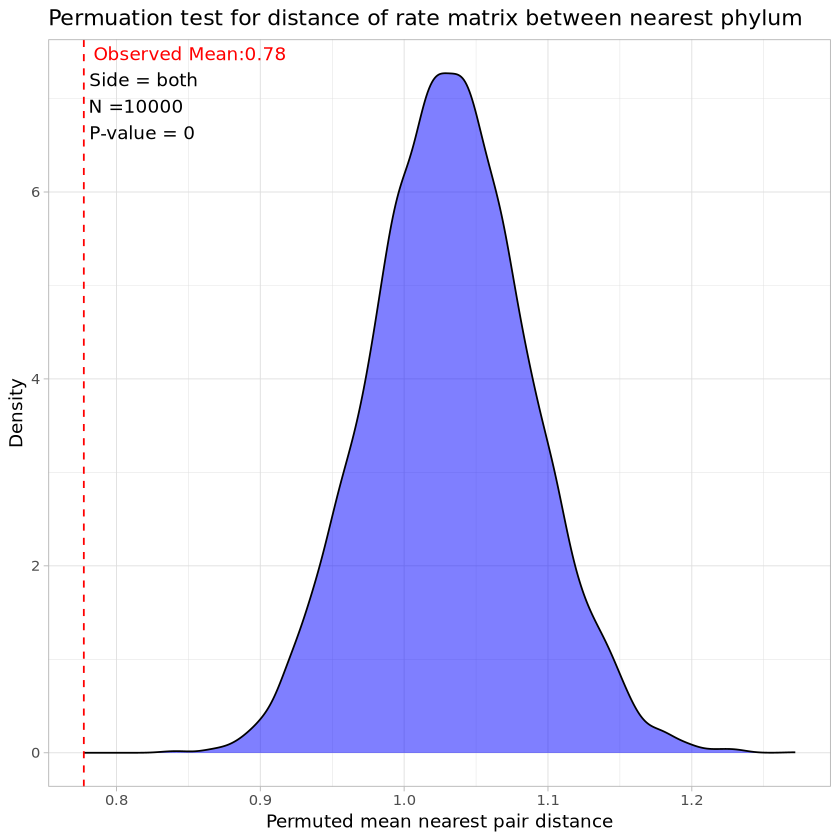

In [40]:
testQ <- near_tips_permutation_test(tree_table = tree_table, dist_table = model_dist_table, tip1 = "phylum1", tip2 = "phylum2", value = "qdist", n_permutations = 10000, side = "both")
testQ$plot + theme_light() + labs(title = "Permuation test for distance of rate matrix between nearest phylum", x = "Permuted mean nearest pair distance", y = "Density")

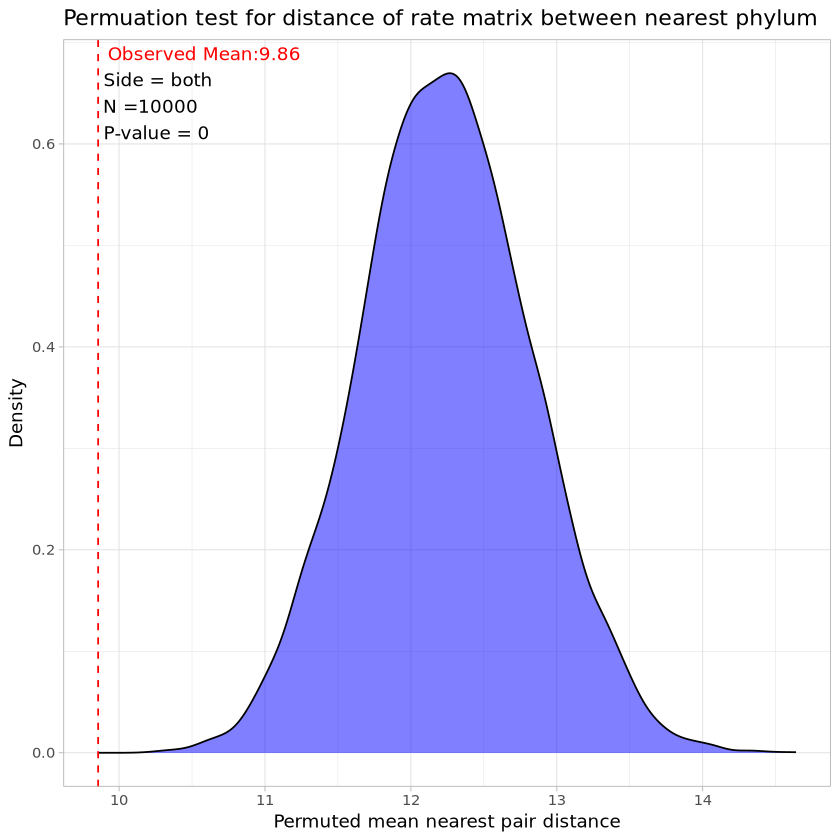

In [41]:
testR <- near_tips_permutation_test(tree_table = tree_table, dist_table = model_dist_table, tip1 = "phylum1", tip2 = "phylum2", value = "rdist", n_permutations = 10000, side = "both")
testR$plot + theme_light() + labs(title = "Permuation test for distance of rate matrix between nearest phylum", x = "Permuted mean nearest pair distance", y = "Density")

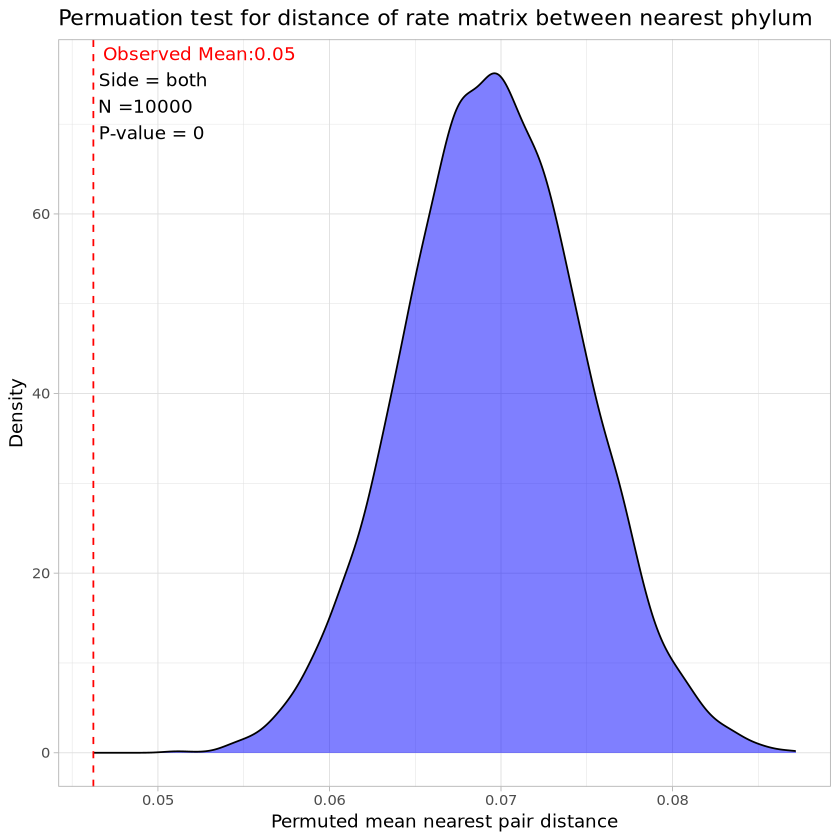

In [42]:
testF <- near_tips_permutation_test(tree_table = tree_table, dist_table = model_dist_table, tip1 = "phylum1", tip2 = "phylum2", value = "fdist", n_permutations = 10000, side = "both")
testF$plot + theme_light() + labs(title = "Permuation test for distance of rate matrix between nearest phylum", x = "Permuted mean nearest pair distance", y = "Density")

In [148]:
combined_table <- tree_table_ref %>%
      left_join(model_dist_table, by = c("tip1" = "phylum1", "tip2" = "phylum2")) %>% drop_na() %>% 
      rename(branch_length_ref = branch_length)

# Perform linear regression
model <- lm(branch_length_ref ~ qdist, data = combined_table)
summary(model)
# Add residuals to the data frame
combined_table <- combined_table %>%
  mutate(residuals = resid(model))

# Sort by absolute value of residuals in descending order
combined_table <- combined_table %>%
  arrange(desc(abs(residuals)))

combined_table2 <- tree_table_QBC %>%
      left_join(model_dist_table, by = c("tip1" = "phylum1", "tip2" = "phylum2")) %>% drop_na() %>% 
      rename(branch_length_QBC = branch_length)
model <- lm(branch_length_QBC ~ qdist, data = combined_table2)
summary(model)


Call:
lm(formula = branch_length_ref ~ qdist, data = combined_table)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.15940 -0.09567 -0.04825  0.08592  0.47901 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.26906    0.06166   4.364 5.56e-05 ***
qdist        0.01592    0.07594   0.210    0.835    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1357 on 56 degrees of freedom
Multiple R-squared:  0.0007846,	Adjusted R-squared:  -0.01706 
F-statistic: 0.04397 on 1 and 56 DF,  p-value: 0.8347



Call:
lm(formula = branch_length_QBC ~ qdist, data = combined_table2)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.28021 -0.11763 -0.04434  0.07189  0.66548 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)   
(Intercept)  0.22479    0.07349   3.059  0.00341 **
qdist        0.20804    0.08537   2.437  0.01801 * 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1964 on 56 degrees of freedom
Multiple R-squared:  0.09588,	Adjusted R-squared:  0.07974 
F-statistic: 5.939 on 1 and 56 DF,  p-value: 0.01801


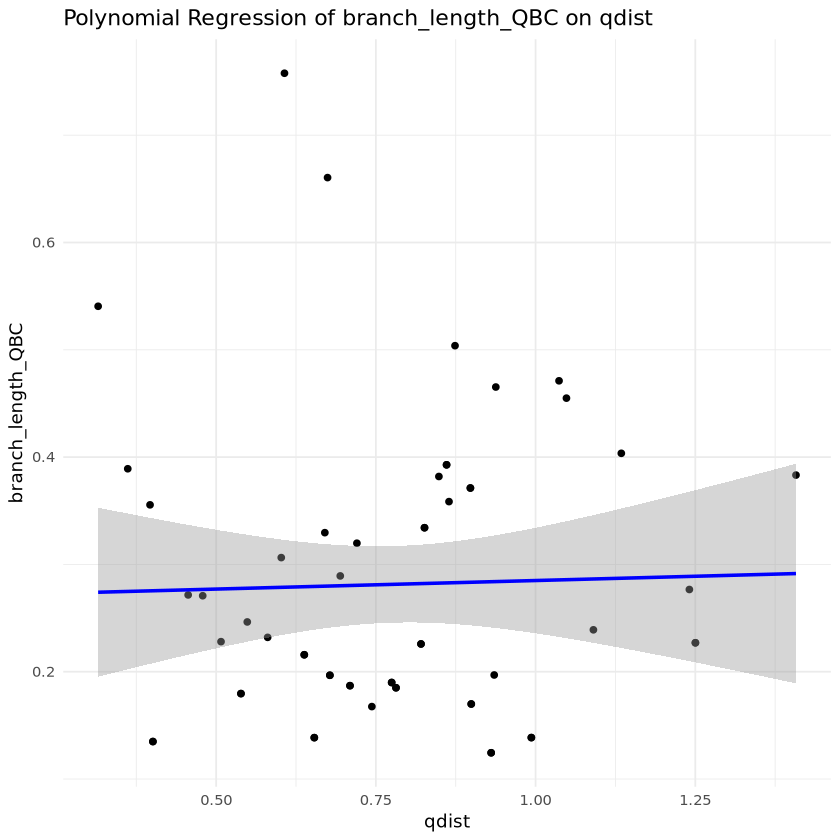

In [147]:
ggplot(combined_table, aes(x = qdist, y = branch_length_ref)) +
  geom_point() +  # 绘制散点图
  geom_smooth(method = "lm", formula = y ~ x, col = "blue") +  # 添加多项式回归线
  labs(title = "Polynomial Regression of branch_length_QBC on qdist",
       x = "qdist",
       y = "branch_length_QBC") +
  theme_minimal()

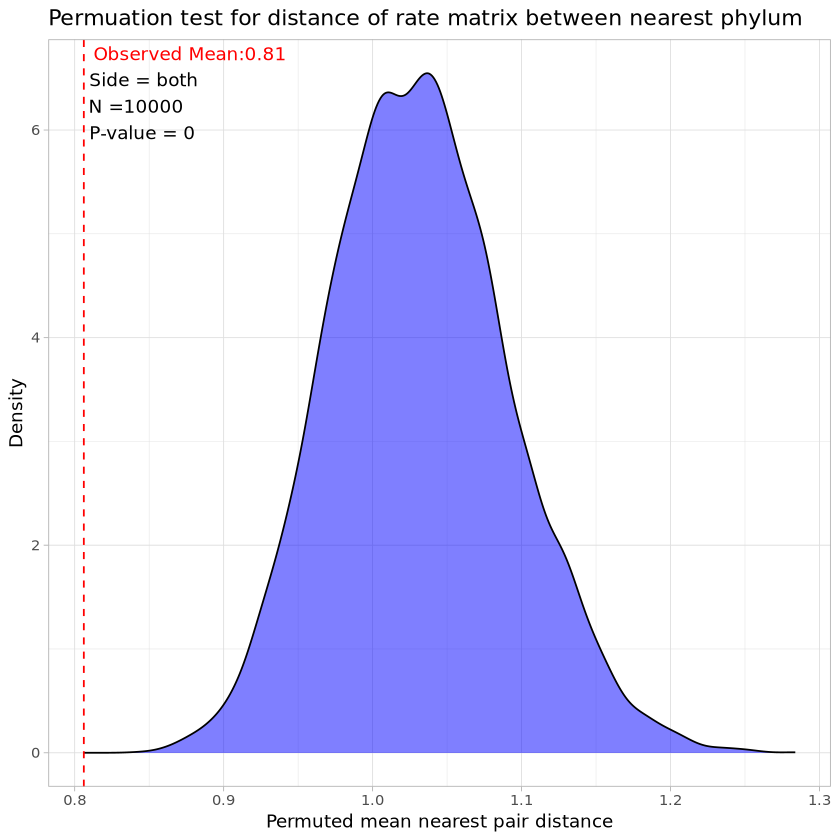

In [54]:
testQ2 <- near_tips_permutation_test(tree_table = tree_table, dist_table = model_dist_table, tip1 = "phylum1", tip2 = "phylum2", value = "qdist", n_permutations = 10000, side = "both")
testQ2$plot + theme_light() + labs(title = "Permuation test for distance of rate matrix between nearest phylum", x = "Permuted mean nearest pair distance", y = "Density")

`geom_smooth()` using formula = 'y ~ x'


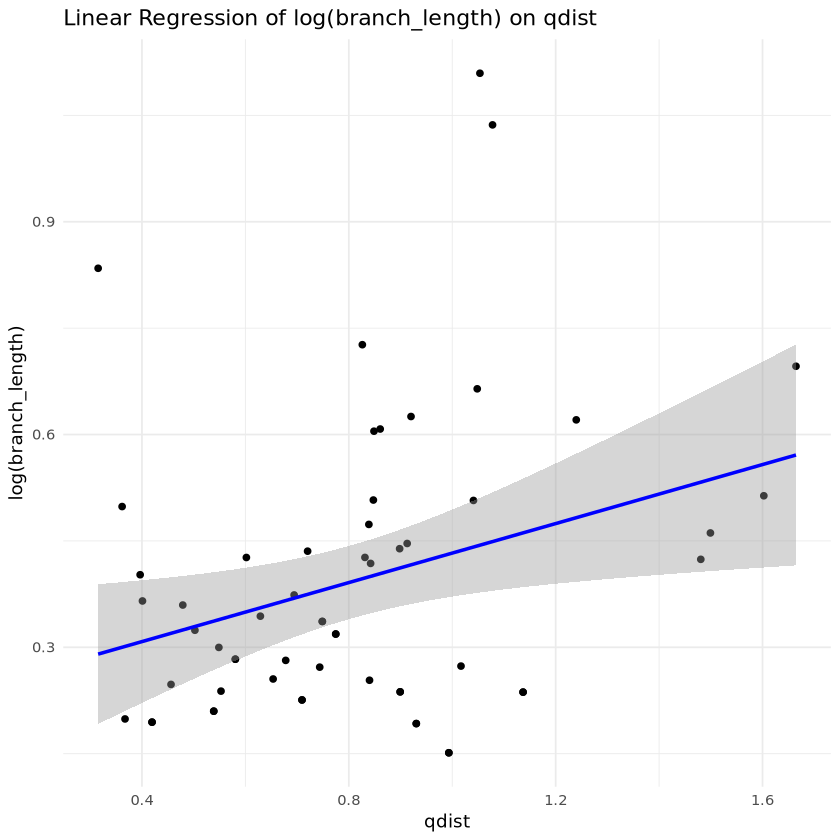

In [66]:
library(ggplot2)
 ggplot(combined_table, aes(x = qdist, y = branch_length)) +
  geom_point() +  
  geom_smooth(method = "lm", col = "blue") +  
  labs(title = "Linear Regression of log(branch_length) on qdist",
       x = "qdist",
       y = "log(branch_length)") +
  theme_minimal()

In [94]:
# Function to find all pairwise distances between tips and return as a data frame
tree_to_all_pairwise_distances <- function(tree_file) {
  # Read the tree from the Newick file
  tree <- read.tree(tree_file)
  
  # Get all pairwise distances
  pairwise_distances <- cophenetic(tree)
  
  # Create a data frame with tip1, tip2, and branch_length
  tip_labels <- tree$tip.label
  n <- length(tip_labels)
  tip_pairs <- data.frame(
    tip1 = rep(tip_labels, each = n),
    tip2 = rep(tip_labels, times = n),
    branch_length = as.vector(pairwise_distances)
  )
  
  return(tip_pairs)
}

tree_dist_all_ref <- tree_to_all_pairwise_distances("/home/tim/project/bacterialQ/analysis/phylum_tree/phylum_backbone_tree_clean.tre")
tree_dist_all_QBC <- tree_to_all_pairwise_distances("/home/tim/project/bacterialQ/Result_nova/extend_global_model_test/trees/FT_Q.Bac_Class_full_backbone_simple.treefile")

combined_table_alldist <- tree_dist_all_ref %>%
      left_join(model_dist_table, by = c("tip1" = "phylum1", "tip2" = "phylum2")) %>% drop_na() %>% 
      rename(branch_length_ref = branch_length) %>%
      left_join(tree_dist_all_QBC, by = c("tip1" = "tip1", "tip2" = "tip2")) %>% drop_na() %>%
      rename(branch_length_QBC = branch_length) %>% 
      filter(tip1 != tip2)

In [104]:
summary(lm(branch_length_QBC ~ fdist, data = combined_table_alldist))


Call:
lm(formula = branch_length_QBC ~ fdist, data = combined_table_alldist)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.72021 -0.19945 -0.02246  0.17863  1.16920 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.80376    0.01117  71.978  < 2e-16 ***
fdist        1.15104    0.14262   8.071  9.7e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.296 on 3304 degrees of freedom
Multiple R-squared:  0.01933,	Adjusted R-squared:  0.01904 
F-statistic: 65.13 on 1 and 3304 DF,  p-value: 9.698e-16


`geom_smooth()` using formula = 'y ~ x'


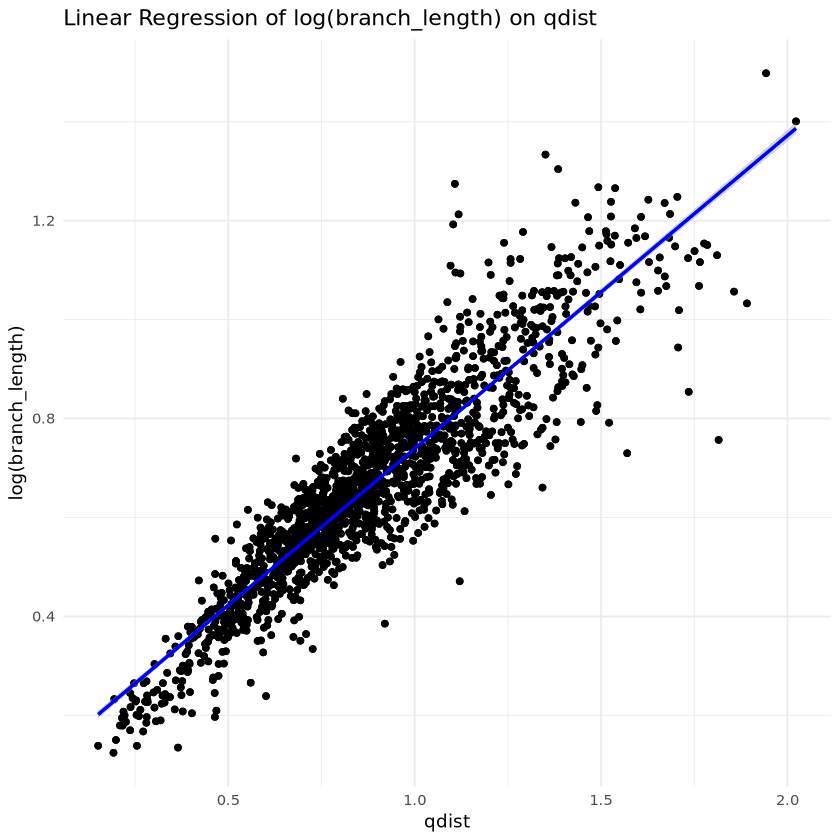

In [113]:
ggplot(combined_table_alldist, aes(x = branch_length_QBC, y = branch_length_ref)) +
  geom_point() +  # 绘制散点图
  geom_smooth(method = "lm", col = "blue") +  # 添加线性回归线
  labs(title = "Linear Regression of log(branch_length) on qdist",
       x = "qdist",
       y = "log(branch_length)") +
  theme_minimal()

In [157]:
combined_table %>% summarise(mean(qdist),mean(rdist),mean(fdist))
combined_table2 %>% summarise(mean(qdist),mean(rdist),mean(fdist))

mean(qdist),mean(rdist),mean(fdist)
<dbl>,<dbl>,<dbl>
0.7773007,9.856511,0.0462374


mean(qdist),mean(rdist),mean(fdist)
<dbl>,<dbl>,<dbl>
0.8061552,10.07708,0.05009396
